In [1]:
#!pip install eli5

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import random
import mofr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             f1_score, precision_score,
                             recall_score, roc_auc_score)
from xgboost import XGBClassifier, plot_tree

import xgboost as xgb

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=True,
C:\

In [4]:
seed=1234

In [5]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
gender_submission=pd.read_csv("gender_submission.csv")

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Data Exploration

In [9]:
train.info()
print('--------------------')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    

In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [12]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [13]:
test.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Kelly, Mr. James",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


# Predictor checking

In [14]:
train['Survived'].value_counts(dropna=False, normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [15]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [16]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [17]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [18]:
from mofr.basic_evaluators.HistogramContinuous import HistogramContinuousEvaluator

hcoe=HistogramContinuousEvaluator()

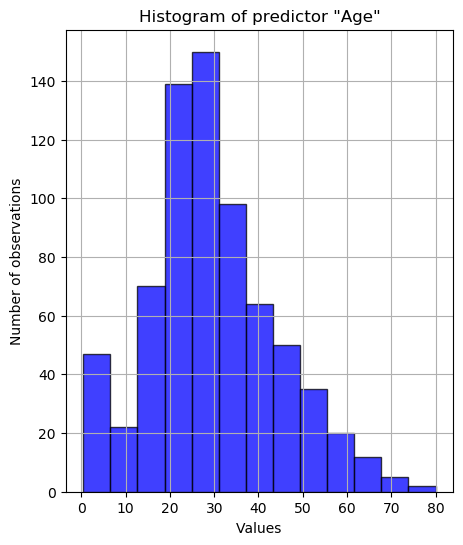

In [19]:
hcoe.d(train[train['Age'].fillna(-1)!=-1]).pc('Age')
hcoe.get_graph()

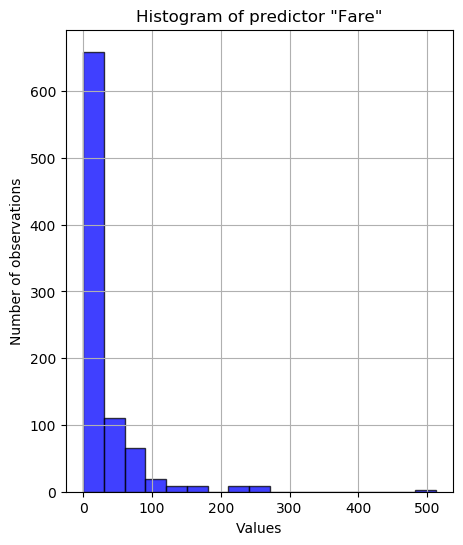

In [20]:
hcoe.d(train[train['Fare'].fillna(-1)!=-1]).pc('Fare')
hcoe.get_graph()

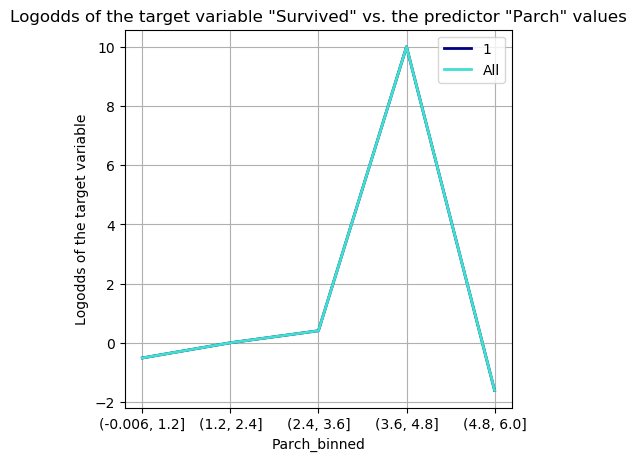

In [21]:
from mofr.basic_evaluators.TargetAssociationContinuous import TargetAssociationContinuousEvaluator

train['one']=1
tacoe=TargetAssociationContinuousEvaluator()
tacoe.d(train.fillna(-1)).t([('Survived', 'one')]).pc('Parch').tc('one')
tacoe.get_graph()

In [22]:
mofr.metrics.gini(train.fillna(-1)['Survived'], train.fillna(-1)['Parch'])

0.12243419721130366

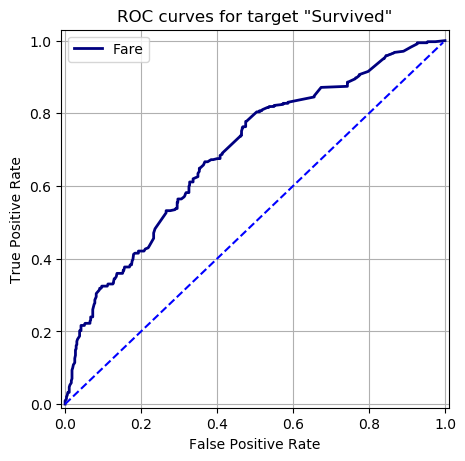

In [23]:
from mofr.basic_evaluators.ROCCurve import ROCCurveEvaluator

rce=ROCCurveEvaluator()
rce.d(train.fillna(-1)).t([('Survived', 'one')]).s(['Fare'])
rce.get_graph()

# Data transformations

In [24]:
def name_trans(x):
    if 'Mr.' in x:
        return 'Mr.'
    elif 'Mrs.' in x:
        return 'Mrs.'
    elif 'Miss.' in x:
        return 'Miss.'
    elif 'Master.' in x:
        return 'Master.'
    else:
        return 'Other'

In [25]:
train['Name'].apply(name_trans).value_counts()

Mr.        517
Miss.      182
Mrs.       125
Master.     40
Other       27
Name: Name, dtype: int64

In [26]:
train['Title']=train['Name'].apply(name_trans)
test['Title']=test['Name'].apply(name_trans)

In [27]:
train['Male_flag']=[1.0 if x=='male' else 0.0 for x in train['Sex']]
test['Male_flag']=[1.0 if x=='male' else 0.0 for x in test['Sex']]

In [28]:
train=train.merge(pd.DataFrame(train.groupby('Ticket')['Sex'].count().reset_index()).rename(columns={"Sex":'Ticket_count'}), how='left')
train=train.merge(pd.DataFrame(train.groupby('Ticket')['Sex'].count().reset_index()).rename(columns={"Sex":'Ticket_count'}), how='left')
test=test.merge(pd.DataFrame(test.groupby('Ticket')['Sex'].count().reset_index()).rename(columns={"Sex":'Ticket_count'}), how='left')
train=train.merge(pd.DataFrame(train.groupby('Cabin')['Sex'].count().reset_index()).rename(columns={"Sex":'Cabin_count'}), how='left')
test=test.merge(pd.DataFrame(test.groupby('Cabin')['Sex'].count().reset_index()).rename(columns={"Sex":'Cabin_count'}), how='left')

In [29]:
train=train.merge(pd.DataFrame(train.groupby('Ticket')['Sex'].count().reset_index()).rename(columns={"Sex":'Ticket_count'}), how='left')

In [30]:
test=test.merge(pd.DataFrame(test.groupby('Ticket')['Sex'].count().reset_index()).rename(columns={"Sex":'Ticket_count'}), how='left')

In [31]:
train=train.merge(pd.DataFrame(train.groupby('Cabin')['Sex'].count().reset_index()).rename(columns={"Sex":'Cabin_count'}), how='left')

In [32]:
test=test.merge(pd.DataFrame(test.groupby('Cabin')['Sex'].count().reset_index()).rename(columns={"Sex":'Cabin_count'}), how='left')

In [33]:
train['Family_members']=train['Parch']+train['SibSp']
test['Family_members']=test['Parch']+test['SibSp']
train['Age_Fare']=train['Age']*train['Fare']
test['Age_Fare']=test['Age']*test['Fare']

In [34]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'one', 'Title',
       'Male_flag', 'Ticket_count', 'Cabin_count', 'Family_members',
       'Age_Fare'],
      dtype='object')

## Categorical transformations

### Target Encoding

In [35]:
import category_encoders as ce

In [36]:
cat_preds = ['Title', 'Embarked']

In [37]:
# bayesian target encoding
encoder = ce.TargetEncoder(min_samples_leaf=1, smoothing=1.0)
encoder.fit_transform(train[cat_preds], train['Survived'])

train = pd.concat([train, encoder.transform(train[cat_preds]).add_prefix("BAYES_")], axis=1)
test = pd.concat([test, encoder.transform(test[cat_preds]).add_prefix("BAYES_")], axis=1)

### One-Hot Encoding

In [38]:
# encoder = ce.OneHotEncoder()
# encoder.fit_transform(train[cat_preds], train['Survived'])

# train = pd.concat([train, encoder.transform(train[cat_preds]).add_prefix("ONEHOT_")], axis=1)
# test = pd.concat([test, encoder.transform(test[cat_preds]).add_prefix("ONEHOT_")], axis=1)

# Fitting models

In [39]:
train['one']=1
test['one']=1

In [40]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'one', 'Title',
       'Male_flag', 'Ticket_count', 'Cabin_count', 'Family_members',
       'Age_Fare', 'BAYES_Title', 'BAYES_Embarked'],
      dtype='object')

In [41]:
# col_preds=[
#  'Pclass',
#  'Age',
#  'SibSp',
#  'Parch',
#  'Fare',
#  'Ticket_count',
#  'Cabin_count',
#  'Male_flag',
#  'BAYES_Title',
#  'BAYES_Embarked',
# #  'Family_members',
#  'Age_Fare'    
# ]

col_preds=[col for col in train.select_dtypes(include=["int","float"]) if col not in ['Survived','PassengerId']]

In [42]:
col_preds

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'one',
 'Male_flag',
 'Ticket_count',
 'Cabin_count',
 'Family_members',
 'Age_Fare',
 'BAYES_Title',
 'BAYES_Embarked']

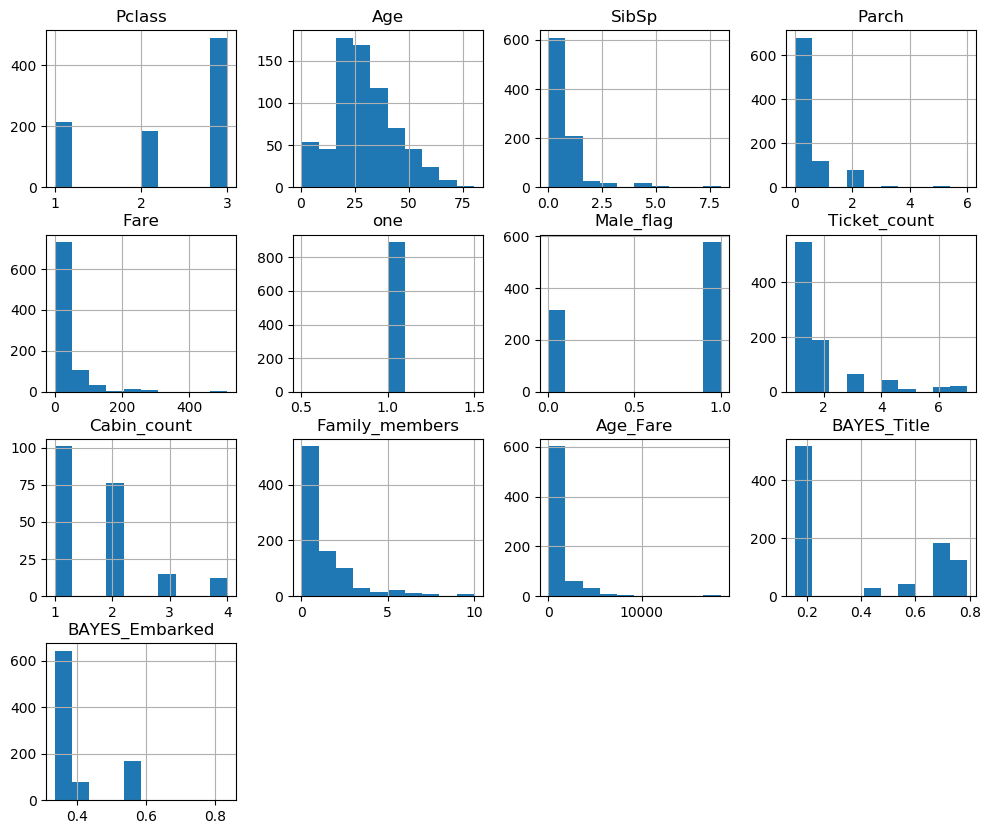

In [43]:
#showing the data
train[col_preds].hist(figsize = (12,10))
plt.show()

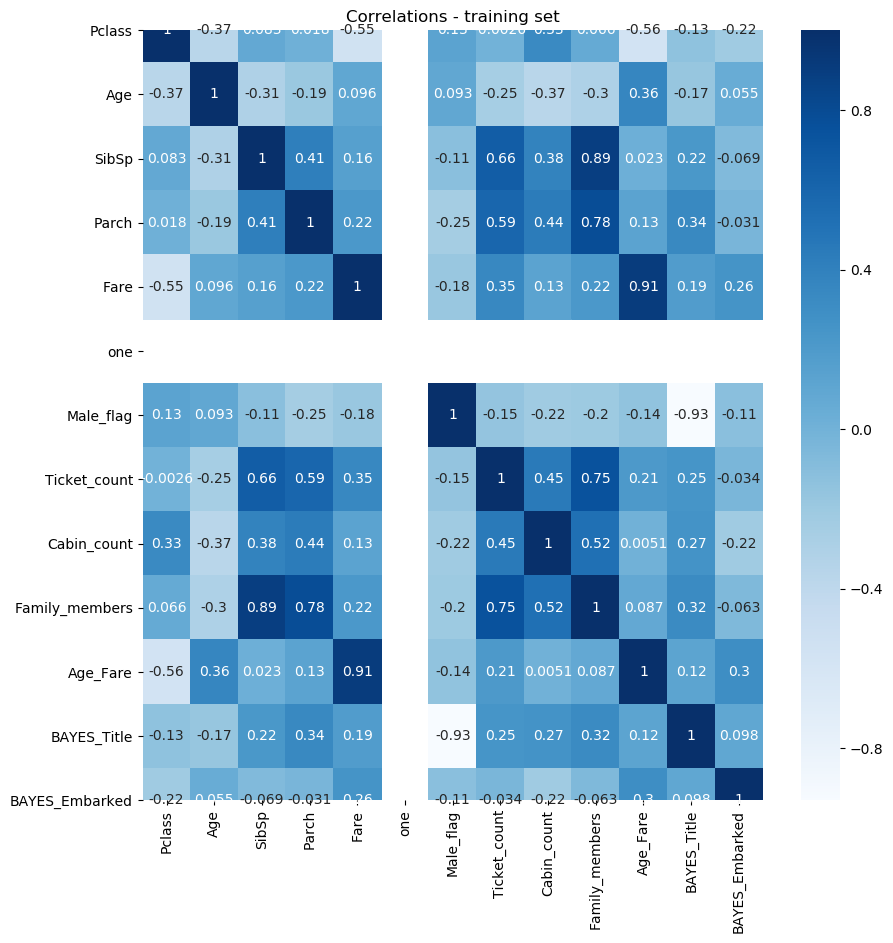

In [44]:
plt.figure(figsize=(10, 10))
ax = plt.axes()
fig = sns.heatmap(train[col_preds].corr(), cbar=True, annot=True, cmap="Blues", ax=ax)
ax.set_title("Correlations - training set")
plt.show()

In [45]:
results=[]
for col in col_preds:
    results.append((col, np.abs(mofr.metrics.gini(train['Survived'], train[col].fillna(-999)))))

pd.DataFrame(results, columns=['Predictor', 'GINI']).sort_values(by='GINI', ascending=False)

,Predictor,GINI
11,BAYES_Title,0.592912
6,Male_flag,0.533746
4,Fare,0.384245
0,Pclass,0.362834
8,Cabin_count,0.283082
10,Age_Fare,0.230387
7,Ticket_count,0.187646
9,Family_members,0.172776
12,BAYES_Embarked,0.155871
3,Parch,0.122434


## XGBoost model

In [46]:
whole_lifts=[]
whole_ginis=[]

train_lifts=[]
train_ginis=[]
train_accuracies=[]

valid_lifts=[]
valid_ginis=[]
valid_accuracies=[]

oot_lifts=[]
oot_ginis=[]
oot_accuracies=[]

n=1
X_train, X_valid, y_train, y_valid= train_test_split(train[0:600], train['Survived'][0:600], test_size=0.2, random_state=seed)
train['FINAL_SCORE_AVG']=0
X_train['FINAL_SCORE_AVG']=0
X_valid['FINAL_SCORE_AVG']=0
test['FINAL_SCORE_AVG']=0

train = train.sample(frac=1).reset_index(drop=True)
#test = test.sample(frac=1).reset_index(drop=True)


for random_seed in range(100):
    X_train, X_valid, y_train, y_valid= train_test_split(train[0:600], train['Survived'][0:600], test_size=0.2, random_state=random_seed)

    xgb_model = XGBClassifier(max_depth=2, seed=random_seed, colsample_bytree=0.5, gamma=1, min_child_weight=5, n_estimators=20)
    xgb_model.fit(X_train.loc[:, col_preds], X_train['Survived'], verbose=0, eval_metric='logloss')
    

    train['FINAL_SCORE'] =xgb_model.predict_proba(train[col_preds])[:, 1]
    X_train['FINAL_SCORE'] =xgb_model.predict_proba(X_train[col_preds])[:, 1]
    X_valid['FINAL_SCORE'] = xgb_model.predict_proba(X_valid[col_preds])[:, 1]
    test['FINAL_SCORE'] =xgb_model.predict_proba(test[col_preds])[:, 1]

        
    train['FINAL_SCORE_AVG'] =(train['FINAL_SCORE_AVG']*n+ xgb_model.predict_proba(train[col_preds])[:, 1])/(n+1)
    X_train['FINAL_SCORE_AVG'] =(X_train['FINAL_SCORE_AVG']*n+xgb_model.predict_proba(X_train[col_preds])[:, 1])/(n+1)
    X_valid['FINAL_SCORE_AVG'] = (X_valid['FINAL_SCORE_AVG']*n+xgb_model.predict_proba(X_valid[col_preds])[:, 1])/(n+1)
    test['FINAL_SCORE_AVG'] = (test['FINAL_SCORE_AVG']*n+xgb_model.predict_proba(test[col_preds])[:, 1])/(n+1)  
    n+=1 
    
    whole_lifts.append(mofr.metrics.lift(train['Survived'], train['FINAL_SCORE']))
    whole_ginis.append(mofr.metrics.gini(train['Survived'], train['FINAL_SCORE']))

    train_lifts.append(mofr.metrics.lift(X_train['Survived'], X_train['FINAL_SCORE']))
    train_ginis.append(mofr.metrics.gini(X_train['Survived'], X_train['FINAL_SCORE']))
    train_accuracies.append(mofr.metrics.accuracy_score(X_train['Survived'], X_train['FINAL_SCORE'].apply(lambda x: int(x>0.5))))

    
    valid_lifts.append(mofr.metrics.lift(X_valid['Survived'], X_valid['FINAL_SCORE']))
    valid_ginis.append(mofr.metrics.gini(X_valid['Survived'], X_valid['FINAL_SCORE']))
    valid_accuracies.append(mofr.metrics.accuracy_score(X_valid['Survived'], X_valid['FINAL_SCORE'].apply(lambda x: int(x>0.5))))

    oot_lifts.append(mofr.metrics.lift(train['Survived'][600:-1], train['FINAL_SCORE'][600:-1]))
    oot_ginis.append(mofr.metrics.gini(train['Survived'][600:-1], train['FINAL_SCORE'][600:-1]))
    oot_accuracies.append(mofr.metrics.accuracy_score(train['Survived'][600:-1], train['FINAL_SCORE'][600:-1].apply(lambda x: int(x>0.5))))

In [47]:
np.std(oot_accuracies)

0.010001842874186

In [48]:
# print('The Lift on the whole set is: '+ str(np.mean(whole_lifts)))
# print('The gini on the whole set is: '+ str(np.mean(whole_ginis)))
# print('\n')
print('The Lift on the train set is: '+ str(np.mean(train_lifts)))
print('The gini on the train set is: '+ str(np.mean(train_ginis)))
print('The acc on the train set is: '+ str(np.mean(train_accuracies)))
print('\n')
print('The Lift on the valid set is: '+ str(np.mean(valid_lifts)))
print('The gini on the valid set is: '+ str(np.mean(valid_ginis)))
print('The acc on the valid set is: '+ str(np.mean(valid_accuracies)))
print('\n')
print('The Lift on the oot set is: '+ str(np.mean(oot_lifts)))
print('The gini on the oot set is: '+ str(np.mean(oot_ginis)))
print('The acc on the oot set is: '+ str(np.mean(oot_accuracies)))

The Lift on the train set is: 2.5742360514831937
The gini on the train set is: 0.8154595708789776
The acc on the train set is: 0.848625


The Lift on the valid set is: 2.551855232155182
The gini on the valid set is: 0.746489811402773
The acc on the valid set is: 0.8144166666666665


The Lift on the oot set is: 2.352323376623377
The gini on the oot set is: 0.7478439393939396
The acc on the oot set is: 0.8349310344827587


In [49]:
# print('The Lift on the whole set is: '+ str(np.mean(whole_lifts)))
# print('The gini on the whole set is: '+ str(np.mean(whole_ginis)))
# print('\n')
print('The Lift on the train set is: '+ str(mofr.metrics.lift(X_train['Survived'], X_train['FINAL_SCORE_AVG'])))
print('The gini on the train set is: '+ str(mofr.metrics.gini(X_train['Survived'], X_train['FINAL_SCORE_AVG'])))
print('The accuracy on the train set is: '+ str(mofr.metrics.accuracy_score(X_train['Survived'], X_train['FINAL_SCORE_AVG'].apply(lambda x: int(x>0.5)))))
print('\n')
print('The Lift on the valid set is: '+ str(mofr.metrics.lift(X_valid['Survived'], X_valid['FINAL_SCORE_AVG'])))
print('The gini on the valid set is: '+ str(mofr.metrics.gini(X_valid['Survived'], X_valid['FINAL_SCORE_AVG'])))
print('The accuracy on the valid set is: '+ str(mofr.metrics.accuracy_score(X_valid['Survived'], X_valid['FINAL_SCORE_AVG'].apply(lambda x: int(x>0.5)))))
print('\n')
print('The Lift on the oot set is: '+ str(mofr.metrics.lift(train['Survived'][600:-1], train['FINAL_SCORE_AVG'][600:-1])))
print('The gini on the oot set is: '+ str(mofr.metrics.gini(train['Survived'][600:-1], train['FINAL_SCORE_AVG'][600:-1])))
print('The accuracy on the oot set is: '+ str(mofr.metrics.accuracy_score(train['Survived'][600:-1], train['FINAL_SCORE_AVG'][600:-1].apply(lambda x: int(x>0.5)))))

The Lift on the train set is: 2.596685082872928
The gini on the train set is: 0.816127422901384
The accuracy on the train set is: 0.84375


The Lift on the valid set is: 2.4
The gini on the valid set is: 0.7988571428571429
The accuracy on the valid set is: 0.8416666666666667


The Lift on the oot set is: 2.2727272727272725
The gini on the oot set is: 0.7510606060606062
The accuracy on the oot set is: 0.8379310344827586


In [50]:
test['Survived']=test['FINAL_SCORE_AVG'].apply(lambda x: int(x>0.5))
test['Survived'].value_counts(normalize=True)

0    0.626794
1    0.373206
Name: Survived, dtype: float64

In [51]:
test[['PassengerId', 'Survived']].to_csv('Prediction_xgb_avg.csv', index=False)

In [52]:
# # make predictions for test and train and valid1, valid2
# y_pred_train = xgb_model.predict(train[col_preds])
# y_pred_prob_train = xgb_model.predict_proba(train[col_preds])[:, 1]

In [53]:
# print('The Lift on the train set is: '+ str(mofr.metrics.lift(train['Survived'], y_pred_prob_train)))
# print('The gini on the train set is: '+ str(mofr.metrics.gini(train['Survived'], y_pred_prob_train)))

### Feature importances (different approaches)

#### xgbooost default feature importance

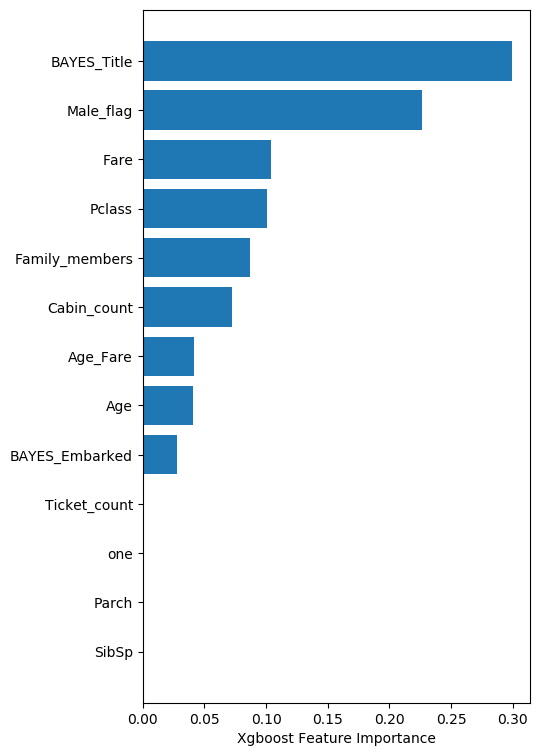

In [54]:
sorted_idx = xgb_model.feature_importances_.argsort()
order_ = []
for i in sorted_idx:
  order_.append(col_preds[i])
plt.figure(figsize=(5, 9))
fig = plt.barh(order_, xgb_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

#### Permutation Importance

In [55]:
#https://www.kaggle.com/code/dansbecker/permutation-importance

In [56]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgb_model, random_state=seed).fit(X_valid[col_preds], X_valid['Survived'])
eli5.show_weights(perm, feature_names = X_train[col_preds].columns.tolist())

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages


Weight,Feature
0.1833 ± 0.0568,BAYES_Title
0.0617 ± 0.0429,Male_flag
0.0583 ± 0.0279,Family_members
0.0483 ± 0.0125,Pclass
0.0433 ± 0.0386,Fare
0.0283 ± 0.0226,Age_Fare
0.0267 ± 0.0323,Age
0.0217 ± 0.0249,BAYES_Embarked
0.0167 ± 0.0183,Cabin_count
0 ± 0.0000,Ticket_count


#### Partial Dependence Plots

In [57]:
#https://www.kaggle.com/code/dansbecker/partial-plots

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


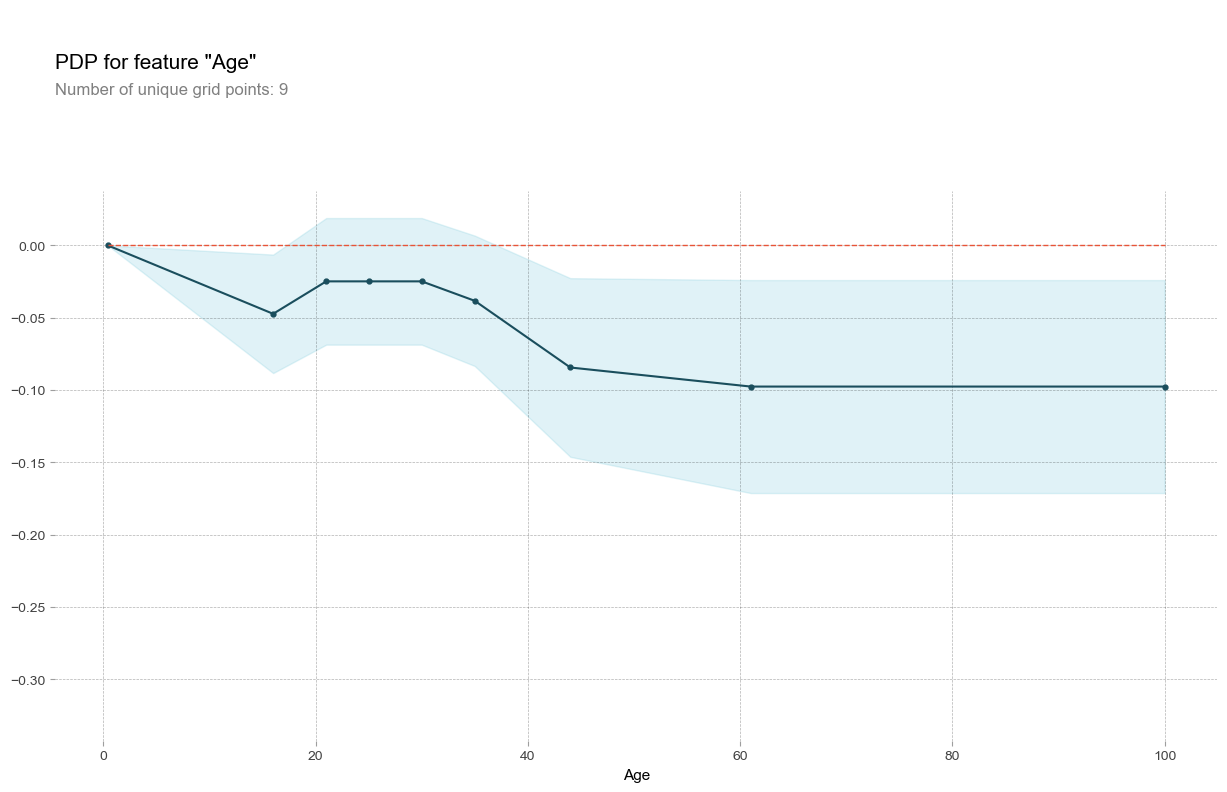

In [58]:
from pdpbox import pdp, get_dataset, info_plots

feature_name='Age'

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=xgb_model, dataset=train.fillna(100), model_features=col_preds, feature=feature_name)

# plot it
pdp.pdp_plot(pdp_goals, feature_name)
plt.show()

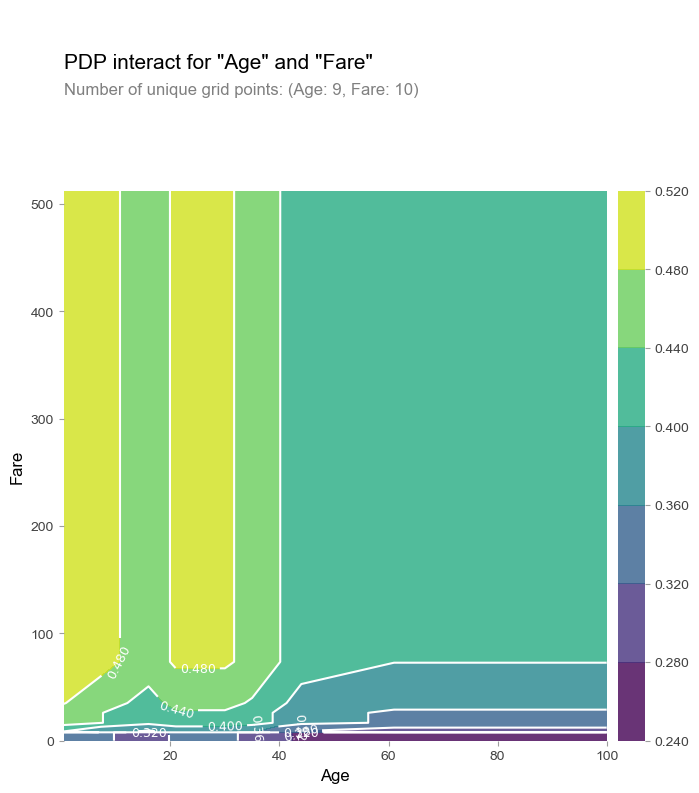

In [59]:
features_to_plot = ['Age', 'Fare']
inter1=pdp.pdp_interact(model=xgb_model, dataset=train.fillna(100), model_features=col_preds, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

#### SHAP values

In [90]:
#https://www.kaggle.com/code/dansbecker/shap-values/tutorial
#https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d
#https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values/tutorial

In [115]:
import shap  # package used to calculate Shap values

In [120]:
row_to_show = 0
data_for_prediction = train[col_preds].iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgb_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

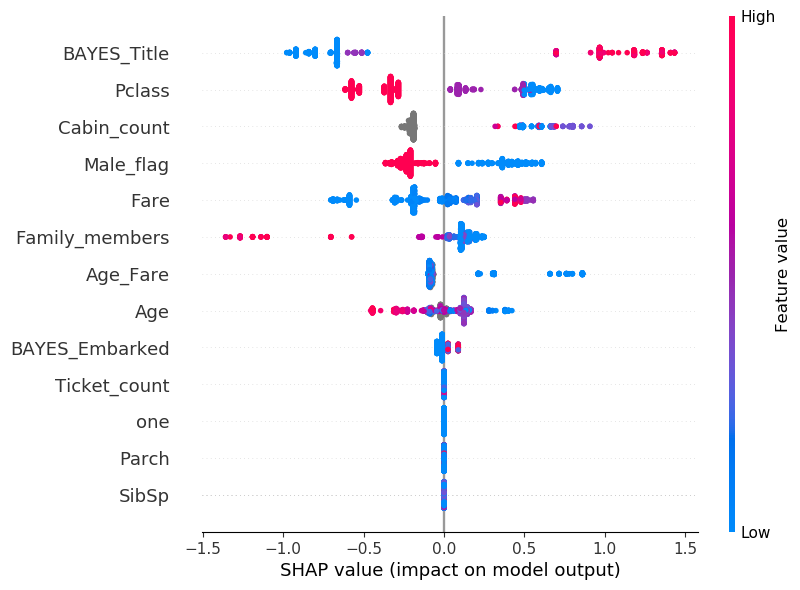

In [124]:
shap_values = explainer.shap_values(train[col_preds])
shap.summary_plot(shap_values, train[col_preds])

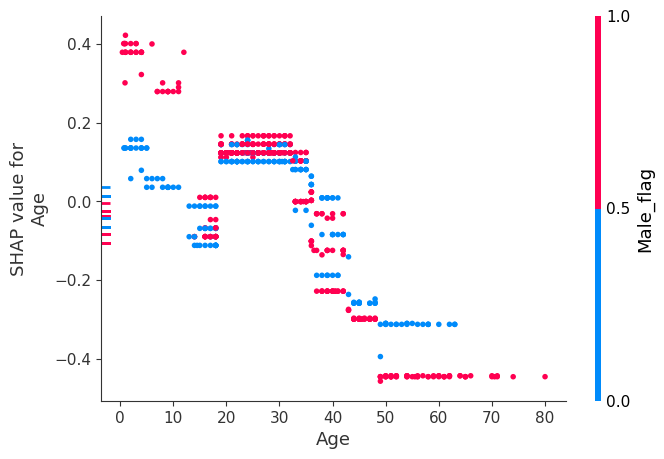

In [125]:
shap.dependence_plot('Age', shap_values, train[col_preds], interaction_index="Male_flag")

## XGBoost model cross validation

In [ ]:
train['Male_flag']

In [ ]:
class SaveBestModel(xgb.callback.TrainingCallback):
    def __init__(self, cvboosters):
        self._cvboosters = cvboosters
    
    def after_training(self, model):
        self._cvboosters[:] = [cvpack.bst for cvpack in model.cvfolds]
        return model

In [ ]:
import os
import xgboost as xgb

# load data in do training
dtrain = xgb.DMatrix(data=train[col_preds],label=train['Survived'])
param = {'max_depth':2, 'seed':seed, 'colsample_bytree':1, 'gamma':1, 'min_child_weight':5}

cvboosters = []

res=xgb.cv(param, dtrain, num_boost_round=10, nfold=5,
             metrics={'auc'}, seed=seed,
             callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True),SaveBestModel(cvboosters)])
res

In [ ]:
xgb_cv_model=cvboosters[4]

In [ ]:
# make predictions for test and train and valid1, valid2
y_pred_prob_train = xgb_cv_model.predict(xgb.DMatrix(train[col_preds]))

In [ ]:
print('The gini on the train set is: '+ str(mofr.metrics.gini(train['Survived'], y_pred_prob_train)))

## Logistic regression model

In [58]:
col_preds

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Ticket_count',
 'Cabin_count',
 'Male_flag',
 'BAYES_Title',
 'BAYES_Embarked',
 'Age_Fare']

In [59]:
import statsmodels.api as sm

lr_cols=col_preds+['one']

for col in lr_cols:
    train[col]=train[col].fillna(np.mean(train[col]))
    test[col]=test[col].fillna(np.mean(train[col]))


X_train, X_valid, y_train, y_valid= train_test_split(train, train['Survived'], test_size=0.2, random_state=seed)

X=X_train[lr_cols]
y=y_train

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.424530
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      700
Method:                           MLE   Df Model:                           11
Date:                Fri, 04 Nov 2022   Pseudo R-squ.:                  0.3603
Time:                        19:29:12   Log-Likelihood:                -302.27
converged:                       True   LL-Null:                       -472.54
Covariance Type:            nonrobust   LLR p-value:                 2.421e-66
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Pclass            -0.9934      0.168     -5.919      0.000      -1.322      -0.664
Age              

In [60]:
whole_lifts=[]
whole_ginis=[]

train_lifts=[]
train_ginis=[]

valid_lifts=[]
valid_ginis=[]

for random_seed in range(100):
    X_train, X_valid, y_train, y_valid= train_test_split(train, train['Survived'], test_size=0.2, random_state=random_seed)

    X=X_train[lr_cols]
    y=y_train

    logit_model=sm.Logit(y,X)
    result=logit_model.fit()
    
    train['FINAL_SCORE'] = result.predict(train[lr_cols])
    X_train['FINAL_SCORE'] = result.predict(X_train[lr_cols])
    X_valid['FINAL_SCORE'] = result.predict(X_valid[lr_cols])
    
    whole_lifts.append(mofr.metrics.lift(train['Survived'], train['FINAL_SCORE']))
    whole_ginis.append(mofr.metrics.gini(train['Survived'], train['FINAL_SCORE']))

    train_lifts.append(mofr.metrics.lift(X_train['Survived'], X_train['FINAL_SCORE']))
    train_ginis.append(mofr.metrics.gini(X_train['Survived'], X_train['FINAL_SCORE']))
    
    valid_lifts.append(mofr.metrics.lift(X_valid['Survived'], X_valid['FINAL_SCORE']))
    valid_ginis.append(mofr.metrics.gini(X_valid['Survived'], X_valid['FINAL_SCORE']))

Optimization terminated successfully.
         Current function value: 0.389594
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415203
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413208
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418575
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426274
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416775
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416260
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.426151
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408641
  

Optimization terminated successfully.
         Current function value: 0.401574
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401012
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419945
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.390723
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412839
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413960
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386784
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405780
  

In [61]:
np.std(valid_ginis)

0.05938961202196195

In [62]:
# print('The Lift on the whole set is: '+ str(np.mean(whole_lifts)))
# print('The gini on the whole set is: '+ str(np.mean(whole_ginis)))
# print('\n')
print('The Lift on the train set is: '+ str(np.mean(train_lifts)))
print('The gini on the train set is: '+ str(np.mean(train_ginis)))
print('\n')
print('The Lift on the valid set is: '+ str(np.mean(valid_lifts)))
print('The gini on the valid set is: '+ str(np.mean(valid_ginis)))

The Lift on the train set is: 2.5264685723146667
The gini on the train set is: 0.7447724808216588


The Lift on the valid set is: 2.5173731782890654
The gini on the valid set is: 0.7299501467010171


In [63]:
# train['FINAL_SCORE'] = result.predict(train[lr_cols])
# X_train['FINAL_SCORE'] = result.predict(X_train[lr_cols])
# X_valid['FINAL_SCORE'] = result.predict(X_valid[lr_cols])

In [64]:
# print('The Lift on the whole set is: '+ str(mofr.metrics.lift(train['Survived'], train['FINAL_SCORE'])))
# print('The gini on the whole set is: '+ str(mofr.metrics.gini(train['Survived'], train['FINAL_SCORE'])))
# print('\n')
# print('The Lift on the train set is: '+ str(mofr.metrics.lift(X_train['Survived'], X_train['FINAL_SCORE'])))
# print('The gini on the train set is: '+ str(mofr.metrics.gini(X_train['Survived'], X_train['FINAL_SCORE'])))
# print('\n')
# print('The Lift on the valid set is: '+ str(mofr.metrics.lift(X_valid['Survived'], X_valid['FINAL_SCORE'])))
# print('The gini on the valid set is: '+ str(mofr.metrics.gini(X_valid['Survived'], X_valid['FINAL_SCORE'])))

In [68]:
import eli5
from eli5.sklearn import PermutationImportance

eli5.show_weights(logit_model, feature_names = X_train[col_preds].columns.tolist())

## Neural network model

In [ ]:
len(col_preds)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=15, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = keras.Sequential([
    
    layers.BatchNormalization(input_shape=[len(col_preds)]), #instead of preprocessing with sklearn

    # the hidden ReLU layers
    layers.Dropout(rate=0.1), # apply 10% dropout to the next layer (to avoid overfitting)
    layers.Dense(units=30, activation='relu'),
    layers.Dense(units=30, activation='relu'),
    # the linear output layer 
    layers.Dense(units=1,activation='sigmoid'), #remove ,activation='sigmoid' for regression problems
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', #change to 'mae' or 'mse' for regression problems
    metrics=[keras.metrics.AUC()]#'binary_accuracy'
)

In [ ]:
history = model.fit(
    X_train[col_preds], X_train['Survived'],
    validation_data=(X_valid[col_preds], X_valid['Survived']),
    batch_size=100,
    callbacks=[early_stopping], # put your callbacks in a list
    epochs=120,
    verbose=0, # suppress output since we'll plot the curves
)

In [ ]:
#Validation loss develoment
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [ ]:
#GINI develoment
(2*history_df.loc[5:, [history_df.columns[1], history_df.columns[3]]]-1).plot()

In [ ]:
train['NN_SCORE']=[x[0] for x in model.predict(train[col_preds])]
test['NN_SCORE']=[x[0] for x in model.predict(test[col_preds])]

In [ ]:
print('The Lift on the train set is: '+ str(mofr.metrics.lift(train['Survived'], train['NN_SCORE'])))
print('The gini on the train set is: '+ str(mofr.metrics.gini(train['Survived'], train['NN_SCORE'])))

In [ ]:
threshold=0.5

In [ ]:
(test['NN_SCORE']>threshold).value_counts(normalize=True)

In [ ]:
test['Survived']=(test['FINAL_SCORE']>threshold).apply(int)

In [ ]:
test[['PassengerId', 'Survived']].to_csv('Prediction_nn.csv', index=False)

In [ ]:
hcoe.d(train).pc('NN_SCORE')
hcoe.get_graph()

# Predictions

In [ ]:
test['one']=1

## Logistic prediction

In [ ]:
test['FINAL_SCORE'] = result.predict(test[lr_cols])

In [ ]:
threshold=0.6577

In [ ]:
(test['FINAL_SCORE']>threshold).value_counts(normalize=True)

In [ ]:
test['Survived']=(test['FINAL_SCORE']>threshold).apply(int)

In [ ]:
test[['PassengerId', 'Survived']].to_csv('Prediction_lr.csv', index=False)

## XGB prediction

In [ ]:
test['Survived']=xgb_model.predict(test[col_preds])

In [ ]:
test['Survived'].value_counts(normalize=True)

In [ ]:
test[['PassengerId', 'Survived']].to_csv('Prediction_xgb.csv', index=False)

## XGB CV prediction

In [ ]:
test['Survived']=xgb_cv_model.predict(xgb.DMatrix(test[col_preds]))
test['Survived']=test['Survived'].apply(lambda x: int(x>0.5))

In [ ]:
test['Survived'].value_counts(normalize=True)

In [ ]:
test[['PassengerId', 'Survived']].to_csv('Prediction_xgb_cv.csv', index=False)